In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import netket as nk

/home/cwpark/acband-laughlin-instability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: With many Markov Chains (e.g GPUs), n_discard_per_chain>5 is often inefficient.

In [2]:
from src.qm_utils.lattice.lattice import Lattice2D
from src.qm_utils.lattice.brillouin_zone import BrillouinZone2D
from src.netket_compat import get_sector_constraints

In [3]:
sqrt3 = np.sqrt(3)
e1 = np.array([1, 0])
e2 = np.array([0, 1])
lB = 1.0
a_M = (((4 * np.pi) / sqrt3) ** 0.5) * lB
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
recip_lattice = lattice.reciprocal()
b = (4 * np.pi) / (a_M * sqrt3)
b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

# N = 27 grid
t1 = (1 / 9) * (b1 - b2)
t2 = (1 / 9) * (b1 - b3)

sample_lattice_27 = Lattice2D(np.stack([t1, t2]))
bz_27 = BrillouinZone2D(lattice, sample_lattice_27)
N_s_27 = bz_27.n_samples

# N = 28 grid
p1 = b1 + t2 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice_28 = sample_lattice_27.transformed(scale=scale, rot=rot)

bz_28 = BrillouinZone2D(lattice, sample_lattice_28)
N_s_28 = bz_28.n_samples

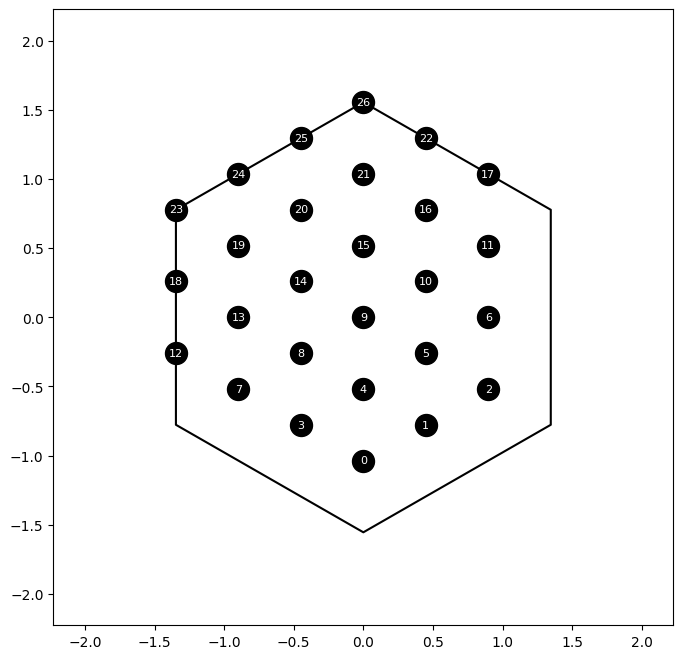

In [4]:
sampled_momentums = bz_27.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s_27):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6 / a_M, 6 / a_M)
ax.set_ylim(-6 / a_M, 6 / a_M)
plt.show()

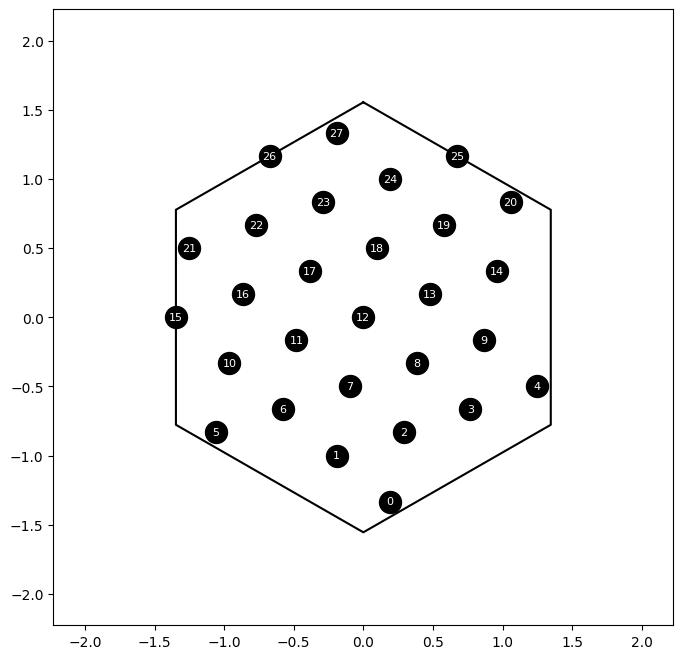

In [5]:
sampled_momentums = bz_28.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s_28):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6 / a_M, 6 / a_M)
ax.set_ylim(-6 / a_M, 6 / a_M)
plt.show()

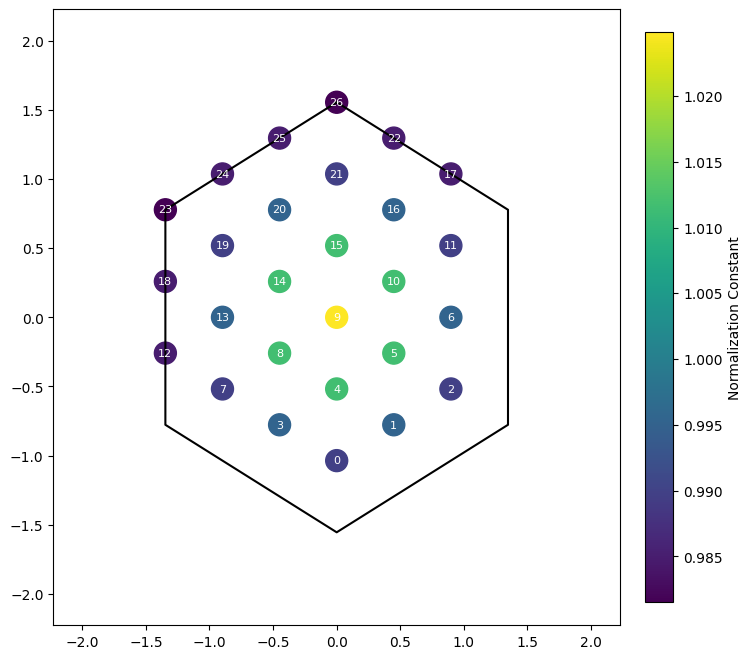

In [6]:
from functools import partial
import time
from src.acband import (
    K_func1,
    wg_fourier_components,
    acband_normalization_constants,
)

lB = 1.0
# resolution = 126
resolution = 254
K = 0.4
K_func = partial(K_func1, args=(K, b1, b2, b3))

# normalization constants test
g_coords, wg = wg_fourier_components(
    K_func, bz_27.lattice, resolution, flatten=False
)
normalizations = acband_normalization_constants(
    bz_27, lB, g_coords, wg, eps=1e-5
)

sampled_momentums = bz_27.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]

# 1. scatter 객체를 변수(sc)에 저장
sc = ax.scatter(k_x, k_y, s=250, c=normalizations, cmap='viridis') # cmap은 원하는대로 변경 가능

for i in range(N_s_27):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6 / a_M, 6 / a_M)
ax.set_ylim(-6 / a_M, 6 / a_M)

# 2. fig.colorbar에 scatter 객체 전달
# fraction, pad 등으로 컬러바 크기와 위치 미세 조정 가능
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Normalization Constant') # 필요시 라벨 추가

plt.show()

In [7]:
from typing import Any, Dict, List

In [ ]:
def calculate_wg_fft_py(fl: Dict[str, Any], Qs: np.ndarray, K_param: float, grid_res: int = 128) -> np.ndarray:
    """
    Julia의 calculate_wg_FFT 함수를 Python(Numpy)으로 변환한 버전입니다.

    Args:
        fl: 'lattice' 키를 포함하는 딕셔너리.
            fl['lattice']는 'Q1', 'Q2', 'a1', 'a2' 키를 가져야 합니다.
        Qs: g 벡터들의 리스트 (예: [[g1x, g1y], [g2x, g2y], ...])
        K_param: K 파라미터 (float)
        grid_res: 실공간 그리드 해상도

    Returns:
        np.ndarray: 계산된 w_g 값 (복소수 배열)
    """
    
    # 1. 딕셔너리에서 격자 벡터 가져오기
    # Julia의 fl.lattice.Q1 -> Python의 fl['lattice']['Q1']
    try:
        lattice_data = fl['lattice']
        Q1 = np.array(lattice_data['Q1'])
        Q2 = np.array(lattice_data['Q2'])
        a1 = np.array(lattice_data['a1'])
        a2 = np.array(lattice_data['a2'])
    except KeyError as e:
        raise KeyError(f"fl 딕셔너리에 필요한 키가 없습니다: {e}. 'fl'은 {{'lattice': {{'Q1': ..., 'Q2': ..., 'a1': ..., 'a2': ...}}}} 구조여야 합니다.")
    
    Q3 = -Q1 - Q2

    # 2. 실공간(UC) 그리드 생성
    # u, v: [0, 1) 범위를 grid_res 단계로 나눔
    u = np.arange(grid_res) / grid_res
    v = np.arange(grid_res) / grid_res
    
    # 2D 그리드 생성. r(u,v) = u*a1 + v*a2
    # Julia의 [ ... for i, j] comprehension -> np.meshgrid
    # 'ij' 인덱싱은 Julia의 루프 순서(i가 첫 번째)와 일치합니다.
    uu, vv = np.meshgrid(u, v, indexing='ij')
    
    # r_grid shape: (grid_res, grid_res, D) (D는 벡터 차원)
    # NumPy 브로드캐스팅 활용: (grid_res, grid_res, 1) * (D,) -> (grid_res, grid_res, D)
    r_grid = uu[..., np.newaxis] * a1 + vv[..., np.newaxis] * a2

    # 3. K(r) 및 fvals = |B(r)|^2 계산 (벡터화 연산)
    pref = -np.sqrt(3) * K_param / (4 * np.pi)
    
    # np.tensordot으로 r_grid와 Q 벡터들의 내적을 한 번에 계산
    # (grid_res, grid_res, D)와 (D,)를 내적 -> (grid_res, grid_res)
    dot_Q1_r = np.tensordot(r_grid, Q1, axes=([-1], [0]))
    dot_Q2_r = np.tensordot(r_grid, Q2, axes=([-1], [0]))
    dot_Q3_r = np.tensordot(r_grid, Q3, axes=([-1], [0]))

    K_r = pref * (np.cos(dot_Q1_r) + np.cos(dot_Q2_r) + np.cos(dot_Q3_r))
    fvals = np.exp(-2 * K_r) # fvals shape: (grid_res, grid_res)

    # 4. w_g 계산
    gNum = Qs.shape[0]
    w_g = np.zeros(gNum, dtype=complex)

    for ig in range(gNum): # 0-based indexing
        g = Qs[ig] # 현재 g 벡터
        
        # g와 모든 r 벡터의 내적 계산
        # (grid_res, grid_res, D)와 (D,) 내적 -> (grid_res, grid_res)
        dot_g_r = np.tensordot(r_grid, g, axes=([-1], [0]))
        
        # 위상항(phasor) 계산 (Julia의 1im -> Python의 1j)
        phasor = np.exp(1j * dot_g_r)
        
        # 합계: s = Σ_r fvals[r] * exp(i * g·r)
        # NumPy의 sum을 사용하여 중첩 루프 대체
        s = np.sum(fvals * phasor)
        
        w_g[ig] = s / (grid_res**2)

    return w_g


def eta_factor(Q_coords: np.ndarray) -> np.ndarray:
    """
    EtaFactor 함수를 Python/NumPy로 포팅한 버전입니다.

    Args:
        Q_coords: g 벡터들의 (gNum, 2) numpy 배열.
    """
    m, n = Q_coords[:, 0], Q_coords[:, 1]
    return (-1) ** ((m + n + m * n) % 2)


def form_factors_LL(
    fl: Dict[str, Any],
    Qs: np.ndarray,         # List[List[float]] -> np.ndarray
    Q_coords: np.ndarray,
    K_param: float,
    eps: float = 1.0e-9
) -> np.ndarray:            # List[np.ndarray] -> np.ndarray
    """
    Julia의 FormFactors_IdealChernBand_1V 함수를 Python/NumPy로 포팅한 버전입니다.
    Qs 인자와 반환형이 numpy 배열로 수정되었습니다.

    Args:
        fl: 'siteNum', 'BZu', 'lattice' 키를 포함하는 딕셔너리.
        Qs: g 벡터들의 (gNum, D) numpy 배열.
        K_param: K 파라미터 (float)
        eps: (현재 코드에서는 사용되지 않음, 원본 시그니처 유지)

    Returns:
        np.ndarray: ff_Lambda (gNum, siteNum, siteNum) 크기의 3D 복소수 배열
    """

    # --- 0. 초기 설정 ---
    try:
        siteNum = fl['siteNum']
        BZu_np = np.array(fl['BZu']) 
        lB2 = fl['lattice']['lB']**2 
    except KeyError as e:
        raise KeyError(f"fl 딕셔너리에 필요한 키가 없습니다: {e}. 'siteNum', 'BZu', 'lattice'{{'lB'}}가 필요합니다.")

    gNum = Qs.shape[0] # len(Qs) -> Qs.shape[0]
    # Qs가 이미 numpy 배열이므로 변환 필요 없음
    # assert np.linalg.norm(Qs[0]) < 1e-12, "expect g=0 at index 0 (Python)"

    # --- 1. 사전 계산 ---
    w_g = calculate_wg_fft_py(fl, Qs, K_param) # (gNum,)

    # --- 2. (A14) 정규화 N_k ---
    Nk = np.zeros(siteNum, dtype=float)
    
    g_dots = np.sum(Qs * Qs, axis=1) # (gNum,)
    gauss_vec_A14 = np.exp(-lB2 * g_dots / 4.0) # (gNum,)
    eta_vec = eta_factor(Q_coords) # (gNum,)

    for ik in range(siteNum):
        k = BZu_np[ik] # (2,)
        phase_vec = lB2 * np.cross(k, Qs) # (gNum,)
        s = np.sum((w_g * eta_vec * np.exp(1j * phase_vec)).real * gauss_vec_A14)
        Nk[ik] = 1.0 / np.sqrt(s)

    # --- 3. (A13) f^{g}_{k,p} ---
    ff_LL = np.zeros((gNum, siteNum, siteNum), dtype=complex)
    
    for ik in range(siteNum):
        k = BZu_np[ik]
        for ip in range(siteNum):
            p = BZu_np[ip]
            
            P_vec = (k - p) - Qs # (gNum, 2)
            Pabs2_vec = lB2 * np.sum(P_vec * P_vec, axis=1) / 2.0 # (gNum,)
            
            phase1_vec = lB2 * np.cross(k + p, Qs) / 2.0 # (gNum,)
            phase2_scalar = lB2 * np.cross(k, p) / 2.0      # (scalar)
            
            gauss_vec_A13 = np.exp(-Pabs2_vec / 2.0)
            
            ff_LL[:, ik, ip] = eta_vec * np.exp(1j * (phase1_vec + phase2_scalar)) * gauss_vec_A13
        
    return Nk, ff_LL

In [9]:
from src.acband import (
    wg_fourier_components,
    acband_normalization_constants,
    LLL_form_factors
)

from einops import rearrange

g_coords, wg = wg_fourier_components(
    K_func, lattice, 126, flatten=False
)
g_coords_flatten = rearrange(g_coords, 'x y d -> (x y) d')

In [10]:
normalizations = acband_normalization_constants(
    bz_27, lB, g_coords, wg, eps=1e-5
)

ff_LLL = LLL_form_factors(
    bz_27, lB, g_coords
)

In [ ]:
fl = {
    'siteNum': 27,
    'BZu': bz_27.k_points,
    'lattice': {
        'a1': lattice.a1,
        'a2': lattice.a2,
        'Q1': lattice.b1,
        'Q2': lattice.b2,
        'lB': lB,
    }
}

gs = recip_lattice.get_points(g_coords_flatten)
Nk_ref, ff_LLL_ref = form_factors_LL(
    fl, gs, g_coords_flatten, K
)

g_coords_flatten.shape=(15876, 2)
gs.shape=(15876, 2)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_grid.shape=(128, 128, 2), g.shape=(2,)
r_g

/tmp/ipykernel_2309594/3170419564.py:135: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  phase_vec = lB2 * np.cross(k, Qs) # (gNum,)
/tmp/ipykernel_2309594/3170419564.py:150: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  phase1_vec = lB2 * np.cross(k + p, Qs) / 2.0 # (gNum,)
/tmp/ipykernel_2309594/3170419564.py:151: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  phase2_scalar = lB2 * np.cross(k, p) / 2.0      # (scalar)
